In [2]:
#导入所需的库
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import plotly.graph_objects as po
import plotly.express as px
import jieba
import jieba.analyse
import codecs
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imageio import imread

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Bilibili_food/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#数据导入

In [4]:
data1=pd.read_csv('BiliBili_FOOD_Video_1.csv')
data2=pd.read_csv('BiliBili_FOOD_Video_2.csv')
data3=pd.read_csv('Bilibili_FOOD_Video_3.csv')
data4=pd.read_csv('Bilibili_FOOD_Video_4.csv')
print(data1.columns.tolist())
print("data1.shape:",data1.shape)
print("data2.shape:",data2.shape)
print("data3.shape:",data3.shape)
print("data4.shape:",data4.shape)

['标题', '总播放数', '总弹幕数', '发布时间', '发布者', '点赞数', '金币数', '收藏量', '分享数', '视频介绍', '标签', '评论数']
data1.shape: (8974, 12)
data2.shape: (17951, 12)
data3.shape: (9628, 12)
data4.shape: (10459, 12)


##合并数据

In [5]:
# 合并数据集
raw_data=pd.concat([data1,data2,data3,data4],axis=0)
raw_data=raw_data.reset_index(drop=True)
raw_data.head()

,标题,总播放数,总弹幕数,发布时间,发布者,点赞数,金币数,收藏量,分享数,视频介绍,标签,评论数
0,活动作品卷饼卷一切 | 麦西恩卷饼 | 早餐,54播放 ·,0弹幕,2021/1/5 14:56,兔巨头_,2\n,\n 投币\n,收藏\n,分享\n,微博:兔巨头_\n公众号:兔巨头 分享日常♡\nThanks for whatchi...,一人食美食美食美食制作\n 出发吧2021\n \n ...,1.0
1,活动作品Vlog71 | 2020年的最后一支vlog| 午餐肉韩式炒饭 | 冬日美食|你好...,3播放 ·,0弹幕,2021/1/5 14:55,杏庄老酒,1\n,\n 投币\n,收藏\n,分享\n,-,家常菜美食美食美食制作\n 人生百味·年度美食大赏\n \n...,0.0
2,50买了一个两斤半的猪肘，小马今天做“红烧猪肘”软烂入味，肥而不腻！,2播放 ·,0弹幕,2021/1/5 14:52,庄味小马,点赞\n,\n 投币\n,收藏\n,分享\n,50买了一个两斤半的猪肘，小马今天做“红烧猪肘”软烂入味，肥而不腻！,烹饪厨艺美食美食美食制作\n 料理制作\n \n ...,0.0
3,新年假期最后一天，杰哥为媳妇孩子逛了又逛，最后买回一兜啥？,1播放 ·,0弹幕,2021/1/5 14:51,杰小郭,点赞\n,\n 投币\n,收藏\n,分享\n,酱大骨头的家常做法，酱味十足，香烂入味，好吃不油腻,烹饪家常菜美食美食美食制作\n 料理制作\n \n ...,0.0
4,吃不完的猪肉，直接放冰箱就错了，教您一招，放30天还是新鲜的,208播放 ·,0弹幕,2021/1/5 14:49,李小米美食,10\n,\n 2\n,4\n,2\n,吃不完的猪肉，直接放冰箱就错了，教您一招，放30天还是新鲜的啊,美食美食美食制作\n 猪肉\n \n 保存...,1.0


In [6]:
raw_data.shape

(47012, 12)

#数据清理

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47012 entries, 0 to 47011
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   标题      47007 non-null  object 
 1   总播放数    46987 non-null  object 
 2   总弹幕数    46971 non-null  object 
 3   发布时间    46965 non-null  object 
 4   发布者     46855 non-null  object 
 5   点赞数     46945 non-null  object 
 6   金币数     46944 non-null  object 
 7   收藏量     46941 non-null  object 
 8   分享数     46941 non-null  object 
 9   视频介绍    43745 non-null  object 
 10  标签      46939 non-null  object 
 11  评论数     9747 non-null   float64
dtypes: float64(1), object(11)
memory usage: 4.3+ MB


In [8]:
column_names = ['title','play_num','bullet_num','release_date','author','good_num','coin_num','keep_num','share_num','intro','category','comment_num']
raw_data.columns = column_names
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47012 entries, 0 to 47011
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         47007 non-null  object 
 1   play_num      46987 non-null  object 
 2   bullet_num    46971 non-null  object 
 3   release_date  46965 non-null  object 
 4   author        46855 non-null  object 
 5   good_num      46945 non-null  object 
 6   coin_num      46944 non-null  object 
 7   keep_num      46941 non-null  object 
 8   share_num     46941 non-null  object 
 9   intro         43745 non-null  object 
 10  category      46939 non-null  object 
 11  comment_num   9747 non-null   float64
dtypes: float64(1), object(11)
memory usage: 4.3+ MB


##去重

In [9]:
raw_data = raw_data.drop_duplicates(subset=['title','release_date','author'])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25610 entries, 0 to 47006
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         25606 non-null  object 
 1   play_num      25585 non-null  object 
 2   bullet_num    25569 non-null  object 
 3   release_date  25563 non-null  object 
 4   author        25491 non-null  object 
 5   good_num      25552 non-null  object 
 6   coin_num      25552 non-null  object 
 7   keep_num      25550 non-null  object 
 8   share_num     25550 non-null  object 
 9   intro         23821 non-null  object 
 10  category      25551 non-null  object 
 11  comment_num   2786 non-null   float64
dtypes: float64(1), object(11)
memory usage: 2.5+ MB


经过去重操作，数据减少了一半，但仍然有2万多的数据量。

##缺失值

In [10]:
raw_data.isnull().sum()

title               4
play_num           25
bullet_num         41
release_date       47
author            119
good_num           58
coin_num           58
keep_num           60
share_num          60
intro            1789
category           59
comment_num     22824
dtype: int64

得知author，share_num，comment_num的缺失量比较多，因此保留这3个特征，将其余的缺失值删掉。

In [11]:
#去除缺失值
data = raw_data[~raw_data[['title', 'play_num', 'bullet_num', 'release_date','good_num',
       'coin_num', 'keep_num', 'share_num', 'category']].isnull().any(axis = 1)]
data = data.reset_index(drop = True)
data.isnull().sum()

title               0
play_num            0
bullet_num          0
release_date        0
author             64
good_num            0
coin_num            0
keep_num            0
share_num           0
intro            1728
category            0
comment_num     22762
dtype: int64

In [12]:
#把缺失值用0代替
for i in ['author','intro','comment_num']:
    data.loc[:,i][data.loc[:,i].isnull()] = '0'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25547 entries, 0 to 25546
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         25547 non-null  object
 1   play_num      25547 non-null  object
 2   bullet_num    25547 non-null  object
 3   release_date  25547 non-null  object
 4   author        25547 non-null  object
 5   good_num      25547 non-null  object
 6   coin_num      25547 non-null  object
 7   keep_num      25547 non-null  object
 8   share_num     25547 non-null  object
 9   intro         25547 non-null  object
 10  category      25547 non-null  object
 11  comment_num   25547 non-null  object
dtypes: object(12)
memory usage: 2.3+ MB


##规范格式

In [14]:
data.head()

,title,play_num,bullet_num,release_date,author,good_num,coin_num,keep_num,share_num,intro,category,comment_num
0,活动作品卷饼卷一切 | 麦西恩卷饼 | 早餐,54播放 ·,0弹幕,2021/1/5 14:56,兔巨头_,2\n,\n 投币\n,收藏\n,分享\n,微博:兔巨头_\n公众号:兔巨头 分享日常♡\nThanks for whatchi...,一人食美食美食美食制作\n 出发吧2021\n \n ...,1
1,活动作品Vlog71 | 2020年的最后一支vlog| 午餐肉韩式炒饭 | 冬日美食|你好...,3播放 ·,0弹幕,2021/1/5 14:55,杏庄老酒,1\n,\n 投币\n,收藏\n,分享\n,-,家常菜美食美食美食制作\n 人生百味·年度美食大赏\n \n...,0
2,50买了一个两斤半的猪肘，小马今天做“红烧猪肘”软烂入味，肥而不腻！,2播放 ·,0弹幕,2021/1/5 14:52,庄味小马,点赞\n,\n 投币\n,收藏\n,分享\n,50买了一个两斤半的猪肘，小马今天做“红烧猪肘”软烂入味，肥而不腻！,烹饪厨艺美食美食美食制作\n 料理制作\n \n ...,0
3,新年假期最后一天，杰哥为媳妇孩子逛了又逛，最后买回一兜啥？,1播放 ·,0弹幕,2021/1/5 14:51,杰小郭,点赞\n,\n 投币\n,收藏\n,分享\n,酱大骨头的家常做法，酱味十足，香烂入味，好吃不油腻,烹饪家常菜美食美食美食制作\n 料理制作\n \n ...,0
4,吃不完的猪肉，直接放冰箱就错了，教您一招，放30天还是新鲜的,208播放 ·,0弹幕,2021/1/5 14:49,李小米美食,10\n,\n 2\n,4\n,2\n,吃不完的猪肉，直接放冰箱就错了，教您一招，放30天还是新鲜的啊,美食美食美食制作\n 猪肉\n \n 保存...,1


In [15]:
#去除换行符
for i in data.columns[:-1]:
    data.loc[:,i] = data.loc[:,i].str.strip().replace('\n', '').replace('\r', '')

In [16]:
#数量为0时的文字替换掉
for i in ['点赞','投币','收藏','分享']:
    data.replace(i,0,inplace = True)

In [17]:
#去除play_num，bullet_num中的文字
play_num = data['play_num'].str.split('播放',expand = True)[0]
bullet_num = data['bullet_num'].str.split('弹幕',expand = True)[0]
data['play_num'] = play_num
data['bullet_num'] = bullet_num

In [18]:
#把万字转化为数学表示
for i in ['play_num','bullet_num','good_num','coin_num','keep_num','share_num']:
    good = data[i][data[i].str.contains('万',na = False,regex = True)].str.split('万',expand=True)[0]
    data.loc[good.index,i] = pd.to_numeric(good) * 10000

In [19]:
#数字项转为int格式
data[['play_num','bullet_num','good_num','coin_num','keep_num','share_num','comment_num']] = data[['play_num','bullet_num','good_num','coin_num','keep_num','share_num','comment_num']].astype('int32')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25547 entries, 0 to 25546
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         25547 non-null  object
 1   play_num      25547 non-null  int32 
 2   bullet_num    25547 non-null  int32 
 3   release_date  25547 non-null  object
 4   author        25547 non-null  object
 5   good_num      25547 non-null  int32 
 6   coin_num      25547 non-null  int32 
 7   keep_num      25547 non-null  int32 
 8   share_num     25547 non-null  int32 
 9   intro         25547 non-null  object
 10  category      25547 non-null  object
 11  comment_num   25547 non-null  int32 
dtypes: int32(7), object(5)
memory usage: 1.7+ MB


In [20]:
#把发布时间划分为年，月，日，时间点
year = []
month = []
day = []
time = []
for i in data['release_date']:
    temp = str(i).split(' ')
    date = temp[0].split('/')
    year.append(int(date[0]))
    month.append(int(date[1]))
    day.append(int(date[2]))
    time.append(int(temp[1].split(':')[0]))
data.insert(4, "year", year, True)
data.insert(5, "month", month, True)
data.insert(6, "day", day, True)
data.insert(7, "time", time, True)

In [21]:
#增加星期的数据
data['week_day'] = pd.to_datetime(data['release_date']).dt.dayofweek + 1

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25547 entries, 0 to 25546
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         25547 non-null  object
 1   play_num      25547 non-null  int32 
 2   bullet_num    25547 non-null  int32 
 3   release_date  25547 non-null  object
 4   year          25547 non-null  int64 
 5   month         25547 non-null  int64 
 6   day           25547 non-null  int64 
 7   time          25547 non-null  int64 
 8   author        25547 non-null  object
 9   good_num      25547 non-null  int32 
 10  coin_num      25547 non-null  int32 
 11  keep_num      25547 non-null  int32 
 12  share_num     25547 non-null  int32 
 13  intro         25547 non-null  object
 14  category      25547 non-null  object
 15  comment_num   25547 non-null  int32 
 16  week_day      25547 non-null  int64 
dtypes: int32(7), int64(5), object(5)
memory usage: 2.6+ MB


In [23]:
data.head()

,title,play_num,bullet_num,release_date,year,month,day,time,author,good_num,coin_num,keep_num,share_num,intro,category,comment_num,week_day
0,活动作品卷饼卷一切 | 麦西恩卷饼 | 早餐,54,0,2021/1/5 14:56,2021,1,5,14,兔巨头_,2,0,0,0,微博:兔巨头_\n公众号:兔巨头 分享日常♡\nThanks for whatchi...,一人食美食美食美食制作\n 出发吧2021\n \n ...,1,2
1,活动作品Vlog71 | 2020年的最后一支vlog| 午餐肉韩式炒饭 | 冬日美食|你好...,3,0,2021/1/5 14:55,2021,1,5,14,杏庄老酒,1,0,0,0,-,家常菜美食美食美食制作\n 人生百味·年度美食大赏\n \n...,0,2
2,50买了一个两斤半的猪肘，小马今天做“红烧猪肘”软烂入味，肥而不腻！,2,0,2021/1/5 14:52,2021,1,5,14,庄味小马,0,0,0,0,50买了一个两斤半的猪肘，小马今天做“红烧猪肘”软烂入味，肥而不腻！,烹饪厨艺美食美食美食制作\n 料理制作\n \n ...,0,2
3,新年假期最后一天，杰哥为媳妇孩子逛了又逛，最后买回一兜啥？,1,0,2021/1/5 14:51,2021,1,5,14,杰小郭,0,0,0,0,酱大骨头的家常做法，酱味十足，香烂入味，好吃不油腻,烹饪家常菜美食美食美食制作\n 料理制作\n \n ...,0,2
4,吃不完的猪肉，直接放冰箱就错了，教您一招，放30天还是新鲜的,208,0,2021/1/5 14:49,2021,1,5,14,李小米美食,10,2,4,2,吃不完的猪肉，直接放冰箱就错了，教您一招，放30天还是新鲜的啊,美食美食美食制作\n 猪肉\n \n 保存...,1,2


#数据分析

##最受欢迎的up主

In [24]:
#2020年10月起每个频道的总播放量，从大到小
data.groupby(by=['author'])['play_num'].sum().sort_values(ascending=False)[:20]

author
盗月社食遇记     41157000
田野上的繁荣     33689000
肉肉大搜索      32719000
徐大sao      30561000
0          30009306
华农兄弟       25353000
吃货请闭眼      23428000
小文哥吃吃吃     22532000
小贝饿了       22402000
密子君        21682000
大祥哥来了      18339000
大庆赶海       17158000
品味新疆       16419000
胖龙的小生活     13646000
绵羊料理       12931000
食贫道        12787000
哇塞几张       11759000
农民工川哥      11430000
波靖仔        11205000
王师傅和小毛毛    10479000
Name: play_num, dtype: int32

In [25]:
#2020年10月起每个频道的总弹幕数排行，从大到小
data.groupby(by=['author'])['bullet_num'].sum().sort_values(ascending=False)[:20]

author
盗月社食遇记      303816
华农兄弟        296000
0           214308
田野上的繁荣      198465
徐大sao       154065
食贫道         144456
李子柒         124000
小贝饿了        118476
密子君         116695
小文哥吃吃吃      114367
胖龙的小生活       98270
非洲飞哥         94295
大祥哥来了        88211
王师傅和小毛毛      87869
吃货请闭眼        85108
肉肉大搜索        81028
罗翔说刑法        78000
记录生活的蛋黄派     75604
波靖仔          75178
品城记本地版       71709
Name: bullet_num, dtype: int32

In [26]:
#2020年10月起每个频道的总点赞数排行，从大到小
data.groupby(by=['author'])['good_num'].sum().sort_values(ascending=False)[:20]

author
盗月社食遇记      3520000
0           2236080
田野上的繁荣      1869000
华农兄弟        1710000
肉肉大搜索       1695647
小文哥吃吃吃      1692000
徐大sao       1415000
大庆赶海        1356000
大祥哥来了       1263000
小贝饿了        1225928
吃货请闭眼       1213000
密子君         1186000
食贫道         1172000
波靖仔         1158071
记录生活的蛋黄派    1156000
王师傅和小毛毛     1010000
农民工川哥        848556
绵羊料理         839000
哇塞几张         745105
老坛胡说         722000
Name: good_num, dtype: int32

In [27]:
#2020年10月起每个频道的总评论数排行，从大到小
data.groupby(by=['author'])['comment_num'].sum().sort_values(ascending=False)[:20]

author
小贝饿了         5608
田野上的繁荣       5384
盗月社食遇记       5379
华农兄弟         3912
大祥哥来了        3819
可爱的土狗哥       3027
胖龙的小生活       2985
大庆赶海         2879
二喵的饭         2734
徐大sao        2506
就是气气         2497
野-食小哥        2458
阿壮锅          2429
小文哥吃吃吃       2400
Yooupi食途     2293
硬核的半佛仙人      2140
吃货请闭眼        2103
渔农小池         1792
花二Strange    1773
食贫道          1753
Name: comment_num, dtype: int32

In [28]:
#2020年10月起每个频道的总分享数排行，从大到小
data.groupby(by=['author'])['share_num'].sum().sort_values(ascending=False)[:20]

author
盗月社食遇记    255423
肉肉大搜索     127521
食贫道       122589
小贝饿了      119002
田野上的繁荣    100496
0          87990
非洲飞哥       79378
密子君        77260
胖龙的小生活     69574
徐大sao      62812
吃货请闭眼      62782
阿壮锅        62541
火腿哥大龙      61176
呼呼美食       54811
渣叔爱酒       54050
农民工川哥      53069
无所尉吃什么     50782
结巴老爹       47930
大庆赶海       47361
杨肉串鸭       47258
Name: share_num, dtype: int32

In [29]:
#2020年10月起每个频道的总收藏数排行，从大到小
data.groupby(by=['author'])['keep_num'].sum().sort_values(ascending=False)[:20]

author
盗月社食遇记      403465
食贫道         307385
0           220933
王师傅和小毛毛     152095
肉肉大搜索       128892
吃货请闭眼        89028
田野上的繁荣       80297
走x琛          80007
小贝饿了         78055
李子柒          75000
小文哥吃吃吃       73485
绵羊料理         73000
华农兄弟         64933
大祥哥来了        64295
密子君          62997
记录生活的蛋黄派     61154
农民工川哥        59341
哇塞几张         58855
波靖仔          56294
孤独的美食基       52465
Name: keep_num, dtype: int32

In [30]:
#2020年10月起每个频道的总投币数排行，从大到小
data.groupby(by=['author'])['coin_num'].sum().sort_values(ascending=False)[:20]

author
盗月社食遇记      1939000
0           1102048
食贫道          917000
王师傅和小毛毛      730748
田野上的繁荣       532951
小文哥吃吃吃       422455
农民工川哥        412002
大祥哥来了        394000
李子柒          383000
华农兄弟         350000
绵羊料理         317000
渔农小池         308144
吃货请闭眼        302907
徐大sao        285236
哇塞几张         276389
滇西小哥         276000
小贝饿了         230134
记录生活的蛋黄派     229000
衣谷水原egg      227000
波靖仔          220066
Name: coin_num, dtype: int32

In [31]:
#2020年10月起每个频道的最高播放量，从大到小
data.groupby(by=['author'])['play_num'].max().sort_values(ascending=False)[:20]

author
罗翔说刑法         6839000
食贫道           6570000
0             6072000
绵羊料理          5102000
盗月社食遇记        4582000
吃货明3          4477000
农民工川哥         4240000
记录生活的蛋黄派      3787000
老坛胡说          3413000
秃草是真的         3334000
李子柒           3161000
吐槽一哥Alonzo    3096000
美食作家王刚R       3010000
贤宝宝Baby       2958000
华农兄弟          2952000
老爸评测          2820000
大祥哥来了         2625000
敬汉卿           2592000
大漠叔叔          2588000
二喵的饭          2472000
Name: play_num, dtype: int32

各个排名里，前20的up主重合度非常高，由此印证了播放量越高，弹幕点赞投币分享收藏的数量也会越多。其中‘盗月社食遇记’在基本上所有榜单中名列第一，除了‘最大播放量’这一排名，其中获得第一名的是‘罗翔说刑法‘，并非美食博主，由此说明只要知名度足够，各个类型的视频都会受到大家的观看。

##美食up主的上传时间

In [32]:
#Top-20up主
popular_list = ['盗月社食遇记', '田野上的繁荣', '肉肉大搜索', '徐大sao', '华农兄弟', '吃货请闭眼', '小贝饿了',
       '密子君', '小文哥吃吃吃', '大祥哥来了', '品味新疆', '大庆赶海', '胖龙的小生活', '绵羊料理', '食贫道',
       '哇塞几张', '农民工川哥', '波靖仔', '王师傅和小毛毛', '记录生活的蛋黄派']

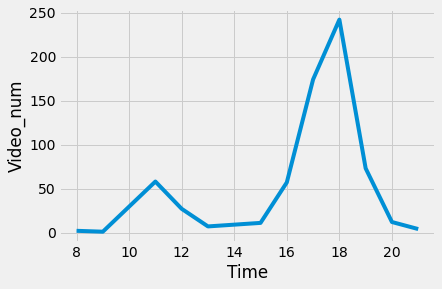

In [33]:
#TOP-20up主各时段的投稿量
plt.style.use("fivethirtyeight")
sns.lineplot(data = data[(data['author'].isin(popular_list))].groupby('time')['play_num'].count())
plt.xlabel('Time')
plt.ylabel('Video_num')
plt.show()

由图可知，绝大多数up主选择在18:00发布视频，也有一小部分选择在11:00发布视频。发布时间刚好是午饭和晚饭的时间，符合美食up主受众群体的喜好。

##美食视频的热门标签

In [34]:
#定义函数，通过结巴分词库中的extract_tags提取category中的关键词，并返回(关键词：播放量)组成的词典
def weighted_tags(item):
    list=jieba.analyse.extract_tags(item.category)
    rlist=dict()
    for i in list:
        rlist[i]=item.play_num
    return rlist

In [35]:
#定义函数，用于累加各行的关键词词典
def list_update(olist,nlist):
    for i in nlist:
        olist[i]=olist.get(i,0)+nlist[i]

In [36]:
tags_total=dict()
for i in data.iterrows():
    i_tags=weighted_tags(i[1])
    list_update(tags_total,i_tags)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.903 seconds.
Prefix dict has been built successfully.


In [37]:
#火热标签top50
popular_tags = sorted(tags_total.items(), key=lambda item:item[1], reverse=True)[:50]
popular_tags

[('美食', 1470438627),
 ('侦探', 684257276),
 ('探店', 496708443),
 ('记录', 493101422),
 ('挑战', 434109162),
 ('生活', 433619854),
 ('百味', 417100909),
 ('人生', 416855165),
 ('吃货', 375373832),
 ('vlog', 320495229),
 ('测评', 288735167),
 ('打卡', 273473529),
 ('街头', 247518140),
 ('大赏', 243464455),
 ('年度', 235844021),
 ('悬赏', 234474150),
 ('VLOG', 231145231),
 ('搞笑', 225133982),
 ('日常', 214072647),
 ('田园', 212526099),
 ('小吃', 202913668),
 ('试吃', 170716814),
 ('11', 135798180),
 ('海鲜', 127543717),
 ('农村', 117916949),
 ('路边摊', 96074221),
 ('UP', 87793054),
 ('火锅', 87070155),
 ('视频', 85499952),
 ('创作', 80975377),
 ('烧烤', 72802465),
 ('开箱', 71496777),
 ('制作', 70272720),
 ('自制', 69199228),
 ('bilibili', 68184382),
 ('计划', 67306283),
 ('新星', 67049132),
 ('必剪', 66059552),
 ('料理', 61796597),
 ('户外', 54252093),
 ('W4', 53746040),
 ('烤肉', 48925695),
 ('赶海', 48027573),
 ('十月', 47810088),
 ('螃蟹', 45947915),
 ('W3', 44911549),
 ('接力', 44453878),
 ('吃饭', 42248666),
 ('家常菜', 42200701),
 ('日本料理', 39222618)]

理所应当的‘美食’是最火热的标签，随后是‘侦探’，‘探店’等。接下来用词云对Top-50标签进行可视化展示。

In [38]:
w = WordCloud(background_color='white',font_path='MSYH.TTC')
top_cate = w.generate_from_frequencies(dict(popular_tags))
w.to_file('top_cate.png')

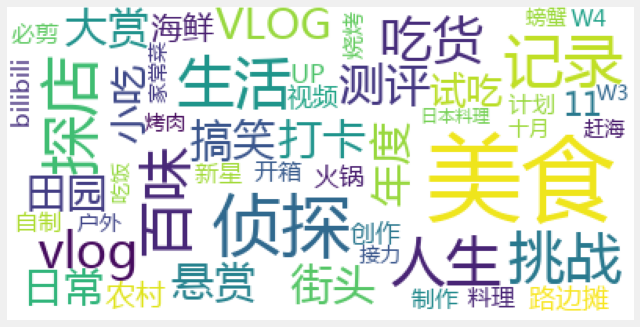

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(top_cate,aspect='equal')
plt.axis("off");

##观众最感兴趣的食物

In [ ]:
#定义函数，通过结巴分词库中的extract_tags提取category中的关键词，并返回(关键词：播放量)组成的词典
def weighted_tags(item):
    list=jieba.analyse.extract_tags(item.category)
    rlist=dict()
    for i in list:
        rlist[i]=item.play_num
    return rlist

In [45]:
#定义函数，通过结巴分词库中的extract_tags提取标题中的关键词，并返回(关键词：播放量)组成的词典
def weighted_list(item):
    list=jieba.analyse.extract_tags(item.title,allowPOS=['n']) #只抽取名词
    print(list)
    rlist=dict()
    for i in list:
        rlist[i]=item.play_num
    return rlist

In [ ]:
#定义函数，用于累加各行的关键词词典
def list_update(olist,nlist):
    for i in nlist:
        olist[i]=olist.get(i,0)+nlist[i]

In [41]:
#定义停用词，用于过滤标题中除了食材外的不相关词
stopwords = [line.strip() for line in open('stopwords_zh.txt', 'r', encoding='utf-8').readlines()]

In [46]:
#遍历data,生成包含所有标题中食材及相应播放量组成的词典，代表每种食材的受欢迎程度
list_total=dict()
for i in data.iterrows():
    i_list=weighted_list(i[1])
    print(i_list)
    list_update(list_total,i_list)

['早餐', '作品']
{'早餐': 54, '作品': 54}
['午餐肉', '新气象', '美食', '作品', '事情']
{'午餐肉': 3, '新气象': 3, '美食': 3, '作品': 3, '事情': 3}
['红烧', '小马']
{'红烧': 2, '小马': 2}
['媳妇', '孩子']
{'媳妇': 1, '孩子': 1}
['冰箱', '猪肉']
{'冰箱': 208, '猪肉': 208}
['鬼畜', '味道']
{'鬼畜': 5, '味道': 5}
['鸡翅', '年糕', '炒菜', '蘑菇']
{'鸡翅': 3, '年糕': 3, '炒菜': 3, '蘑菇': 3}
['午餐', '作品']
{'午餐': 4, '作品': 4}
['草莓', '作品']
{'草莓': 197, '作品': 197}
['口水鸡', '川菜', '公鸡', '作品', '大家']
{'口水鸡': 0, '川菜': 0, '公鸡': 0, '作品': 0, '大家': 0}
['美食', '厨艺', '中餐', '韭黄', '家常菜', '居家', '作品']
{'美食': 3, '厨艺': 3, '中餐': 3, '韭黄': 3, '家常菜': 3, '居家': 3, '作品': 3}
['甜品', '作品']
{'甜品': 6, '作品': 6}
['上桌', '鸡蛋', '娃娃', '作品']
{'上桌': 2, '鸡蛋': 2, '娃娃': 2, '作品': 2}
['油炸', '茄子', '油腻', '技巧', '学会']
{'油炸': 64, '茄子': 64, '油腻': 64, '技巧': 64, '学会': 64}
['作品']
{'作品': 2}
['海苔', '教会', '作品']
{'海苔': 30, '教会': 30, '作品': 30}
['美食', '学会', '作品']
{'美食': 26, '学会': 26, '作品': 26}
['蛋糕', '作品']
{'蛋糕': 5, '作品': 5}
['流口水', '过瘾', '作品']
{'流口水': 1365, '过瘾': 1365, '作品': 1365}
['肉片', '面子', '技巧', '学会', '客人', '作品']
{'肉片': 11, '面子'

AttributeError: ignored